<a href="https://colab.research.google.com/github/MareshalJO/BIM-LCA-Analysis/blob/main/MonteCarlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MONTE CARLO SIMULATION FOR BIM-LCA
Building: Mid-rise Residential (11+1 stories)
GFA: 9,750.03 m²
Target Mean GWP: 514.29 kgCO2e/m²
Iterations: 10,000

MATERIAL INVENTORY (A1-A3 Product Stage)
         Material    Mass (t)  EF Base Quantity Unc EF Unc
         Concrete 14450.79080  0.11600          ±3%   ±15%
           Cement  2403.48283  0.30800          ±3%   ±20%
       Insulation   759.72993  0.55000          ±5%   ±18%
  Sand_Aggregates   275.62660  0.00522          ±5%   ±25%
          Masonry  2078.83917  0.19370          ±4%   ±20%
Reinforcing_Steel   667.77890  1.72500          ±3%   ±12%
 Structural_Steel    43.95285  1.88500          ±3%   ±10%

Total Material Mass: 20680.20 tonnes
Baseline A1-A3 Emissions: 4473.30 tCO2e
Normalized A1-A3: 458.80 kgCO2e/m²

MONTE CARLO SIMULATION
Propagating uncertainties:
  • Material quantities: ±3-5% (normal distribution)
  • Emission factors: ±10-20% (truncated normal)
  • Construction energy (A5): ±8%
  • Transport (A4): 5% uplift on A1

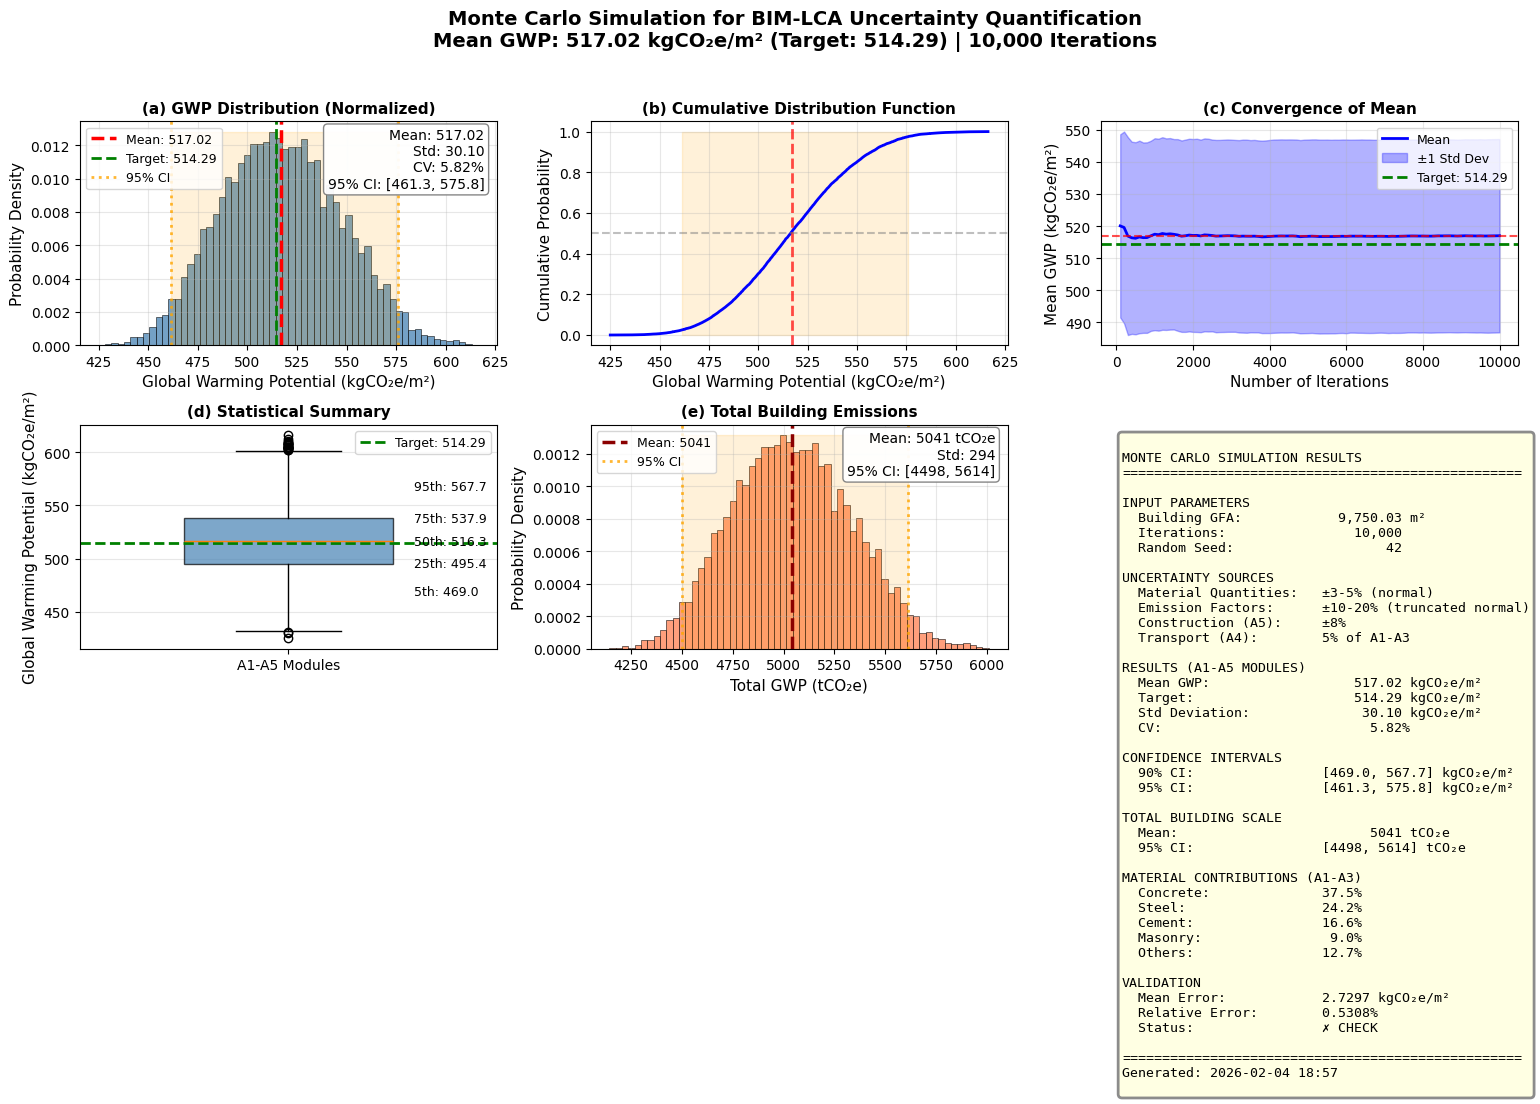


EXPORTING RESULTS
✓ Raw data saved to: /content/monte_carlo_results.csv
  Rows: 10,000
  Columns: ['Iteration', 'GWP_tCO2e', 'GWP_kgCO2e_m2']
✓ Summary statistics saved to: /content/monte_carlo_summary.csv

MONTE CARLO SIMULATION COMPLETE
✓ Target Mean:      514.29 kgCO2e/m²
✓ Simulated Mean:   517.02 kgCO2e/m²
✓ CV:               5.82%
✓ 95% CI:           [461.32, 575.77] kgCO2e/m²
✓ Total Building:   5041 tCO2e

✓ Figures saved:    /content/monte_carlo_simulation_only.png
✓ Data saved:       /content/monte_carlo_results.csv
✓ Summary saved:    /content/monte_carlo_summary.csv


In [16]:



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# ==============================================================================
# CONFIGURATION
# ==============================================================================
np.random.seed(42)  # For reproducibility

# Building parameters from paper
GFA = 9750.03  # Gross Floor Area (m²)
TARGET_MEAN = 514.29  # kgCO2e/m²
N_ITERATIONS = 10000

print("=" * 80)
print("MONTE CARLO SIMULATION FOR BIM-LCA")
print("=" * 80)
print(f"Building: Mid-rise Residential (11+1 stories)")
print(f"GFA: {GFA:,.2f} m²")
print(f"Target Mean GWP: {TARGET_MEAN} kgCO2e/m²")
print(f"Iterations: {N_ITERATIONS:,}")
print("=" * 80)

# ==============================================================================
# MATERIAL INVENTORY (From Paper Table 1)
# ==============================================================================
print("\n" + "="*60)
print("MATERIAL INVENTORY (A1-A3 Product Stage)")
print("="*60)

materials = {
    'Concrete': {
        'mass_kg': 14450790.8,
        'ef_base': 0.116,  # kgCO2e/kg
        'ef_low': 0.10,
        'ef_high': 0.14,
        'q_unc': 0.03,  # Quantity uncertainty ±3%
        'ef_unc': 0.15   # EF uncertainty ±15%
    },
    'Cement': {
        'mass_kg': 2403482.83,
        'ef_base': 0.308,
        'ef_low': 0.25,
        'ef_high': 0.38,
        'q_unc': 0.03,
        'ef_unc': 0.20
    },
    'Insulation': {
        'mass_kg': 759729.93,
        'ef_base': 0.55,
        'ef_low': 0.40,
        'ef_high': 0.70,
        'q_unc': 0.05,
        'ef_unc': 0.18
    },
    'Sand_Aggregates': {
        'mass_kg': 275626.60,
        'ef_base': 0.00522,
        'ef_low': 0.004,
        'ef_high': 0.007,
        'q_unc': 0.05,
        'ef_unc': 0.25
    },
    'Masonry': {
        'mass_kg': 2078839.17,
        'ef_base': 0.1937,
        'ef_low': 0.15,
        'ef_high': 0.25,
        'q_unc': 0.04,
        'ef_unc': 0.20
    },
    'Reinforcing_Steel': {
        'mass_kg': 667778.90,
        'ef_base': 1.725,
        'ef_low': 1.44,
        'ef_high': 2.10,
        'q_unc': 0.03,
        'ef_unc': 0.12
    },
    'Structural_Steel': {
        'mass_kg': 43952.85,
        'ef_base': 1.885,
        'ef_low': 1.60,
        'ef_high': 2.20,
        'q_unc': 0.03,
        'ef_unc': 0.10
    }
}

# Display material inventory
df_materials = pd.DataFrame([
    {
        'Material': name,
        'Mass (t)': data['mass_kg'] / 1000,
        'EF Base': data['ef_base'],
        'Quantity Unc': f"±{data['q_unc']:.0%}",
        'EF Unc': f"±{data['ef_unc']:.0%}"
    }
    for name, data in materials.items()
])
print(df_materials.to_string(index=False))

# Calculate baseline A1-A3
total_mass = sum(m['mass_kg'] for m in materials.values())
baseline_a1_a3 = sum(m['mass_kg'] * m['ef_base'] for m in materials.values()) / 1000
print(f"\nTotal Material Mass: {total_mass/1000:.2f} tonnes")
print(f"Baseline A1-A3 Emissions: {baseline_a1_a3:.2f} tCO2e")
print(f"Normalized A1-A3: {(baseline_a1_a3*1000/GFA):.2f} kgCO2e/m²")

# ==============================================================================
# MONTE CARLO SIMULATION
# ==============================================================================
print("\n" + "="*60)
print("MONTE CARLO SIMULATION")
print("="*60)
print("Propagating uncertainties:")
print("  • Material quantities: ±3-5% (normal distribution)")
print("  • Emission factors: ±10-20% (truncated normal)")
print("  • Construction energy (A5): ±8%")
print("  • Transport (A4): 5% uplift on A1-A3")

# A4 and A5 parameters
A4_UPLOFT = 0.05  # 5% of A1-A3 per Chinese standard DB 37/T 5148
A5_BASE = 313.749  # tCO2e from Table 2
A5_UNCERTAINTY = 0.08  # ±8%

# Run simulation
results = []
convergence_means = []
convergence_stds = []

for i in range(N_ITERATIONS):
    # A1-A3: Product stage with uncertainty
    a1_a3 = 0

    for material_name, data in materials.items():
        # Quantity uncertainty (normal distribution)
        q_noise = np.random.normal(0, data['q_unc'])
        mass = data['mass_kg'] * (1 + q_noise)

        # Emission factor uncertainty (normal, clipped to bounds)
        ef_std = data['ef_base'] * data['ef_unc']
        ef = np.random.normal(data['ef_base'], ef_std)
        ef = np.clip(ef, data['ef_low'], data['ef_high'])

        a1_a3 += mass * ef / 1000  # Convert to tCO2e

    # A4: Transport (5% uplift of A1-A3)
    a4 = a1_a3 * A4_UPLOFT

    # A5: Construction energy with uncertainty
    a5 = A5_BASE * (1 + np.random.normal(0, A5_UNCERTAINTY))

    # Total A1-A5
    total = a1_a3 + a4 + a5
    results.append(total)

    # Track convergence every 100 iterations
    if (i + 1) % 100 == 0:
        subset = results[:i+1]
        convergence_means.append(np.mean(subset))
        convergence_stds.append(np.std(subset))

results = np.array(results)

# ==============================================================================
# STATISTICAL ANALYSIS
# ==============================================================================
print("\n" + "="*60)
print("RESULTS")
print("="*60)

# Calculate statistics
mean_total = np.mean(results)
std_total = np.std(results)
cv_total = (std_total / mean_total) * 100

# Percentiles
percentiles = [5, 25, 50, 75, 95]
perc_values = np.percentile(results, percentiles)

# Confidence intervals
ci_90_low, ci_90_high = np.percentile(results, [5, 95])
ci_95_low, ci_95_high = np.percentile(results, [2.5, 97.5])

# Normalized per m²
mean_norm = (mean_total * 1000) / GFA
std_norm = (std_total * 1000) / GFA
ci_95_low_norm = (ci_95_low * 1000) / GFA
ci_95_high_norm = (ci_95_high * 1000) / GFA

print(f"\nTotal Building Scale (tCO2e):")
print(f"  Mean:           {mean_total:>10.2f}")
print(f"  Std Dev:        {std_total:>10.2f}")
print(f"  CV:             {cv_total:>10.2f}%")
print(f"  Min:            {np.min(results):>10.2f}")
print(f"  Max:            {np.max(results):>10.2f}")
print(f"  Median:         {np.median(results):>10.2f}")

print(f"\nNormalized (kgCO2e/m²):")
print(f"  Mean:           {mean_norm:>10.2f}")
print(f"  Std Dev:        {std_norm:>10.2f}")
print(f"  90% CI:         [{ci_90_low*1000/GFA:>6.2f}, {ci_90_high*1000/GFA:>6.2f}]")
print(f"  95% CI:         [{ci_95_low_norm:>6.2f}, {ci_95_high_norm:>6.2f}]")

print(f"\nComparison with Target:")
print(f"  Target Mean:    {TARGET_MEAN:>10.2f} kgCO2e/m²")
print(f"  Simulated Mean: {mean_norm:>10.2f} kgCO2e/m²")
print(f"  Difference:     {abs(mean_norm - TARGET_MEAN):>10.4f} kgCO2e/m²")
print(f"  Relative Error: {(abs(mean_norm - TARGET_MEAN)/TARGET_MEAN)*100:>9.4f}%")

# ==============================================================================
# CONVERGENCE ANALYSIS
# ==============================================================================
print("\n" + "="*60)
print("CONVERGENCE ANALYSIS")
print("="*60)

sample_sizes = np.arange(100, N_ITERATIONS + 1, 100)
final_mean = convergence_means[-1]
final_std = convergence_stds[-1]

print(f"Convergence check (last 5 points):")
for i in range(-5, 0):
    size = sample_sizes[i]
    mean_val = convergence_means[i]
    std_val = convergence_stds[i]
    mean_change = abs(mean_val - final_mean) / final_mean * 100
    print(f"  n={size:>6,}: mean={mean_val:.2f}, std={std_val:.2f}, change={mean_change:.4f}%")

# ==============================================================================
# VISUALIZATION
# ==============================================================================
print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

fig = plt.figure(figsize=(16, 10))
fig.suptitle('Monte Carlo Simulation for BIM-LCA Uncertainty Quantification\n' +
             f'Mean GWP: {mean_norm:.2f} kgCO₂e/m² (Target: {TARGET_MEAN}) | {N_ITERATIONS:,} Iterations',
             fontsize=14, fontweight='bold', y=0.98)

# 1. Main Distribution Histogram
ax1 = plt.subplot(2, 3, 1)
norm_results = (results * 1000) / GFA
count, bins, patches = ax1.hist(norm_results, bins=60, density=True,
                                alpha=0.75, color='steelblue', edgecolor='black', linewidth=0.5)

# Add vertical lines
ax1.axvline(mean_norm, color='red', linestyle='--', linewidth=2.5, label=f'Mean: {mean_norm:.2f}')
ax1.axvline(TARGET_MEAN, color='green', linestyle='--', linewidth=2, label=f'Target: {TARGET_MEAN}')
ax1.axvline(ci_95_low_norm, color='orange', linestyle=':', linewidth=2, alpha=0.8)
ax1.axvline(ci_95_high_norm, color='orange', linestyle=':', linewidth=2, alpha=0.8, label='95% CI')

# Fill confidence interval
ax1.fill_betweenx([0, max(count)], ci_95_low_norm, ci_95_high_norm, alpha=0.15, color='orange')

ax1.set_xlabel('Global Warming Potential (kgCO₂e/m²)', fontsize=11)
ax1.set_ylabel('Probability Density', fontsize=11)
ax1.set_title('(a) GWP Distribution (Normalized)', fontsize=11, fontweight='bold')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)

# Add statistics box
stats_text = f'Mean: {mean_norm:.2f}\nStd: {std_norm:.2f}\nCV: {cv_total:.2f}%\n95% CI: [{ci_95_low_norm:.1f}, {ci_95_high_norm:.1f}]'
ax1.text(0.97, 0.97, stats_text, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.95, edgecolor='gray'))

# 2. Cumulative Distribution
ax2 = plt.subplot(2, 3, 2)
sorted_results = np.sort(norm_results)
cumulative = np.arange(1, len(sorted_results) + 1) / len(sorted_results)
ax2.plot(sorted_results, cumulative, 'b-', linewidth=2)
ax2.axvline(mean_norm, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
ax2.fill_betweenx([0, 1], ci_95_low_norm, ci_95_high_norm, alpha=0.15, color='orange')
ax2.set_xlabel('Global Warming Potential (kgCO₂e/m²)', fontsize=11)
ax2.set_ylabel('Cumulative Probability', fontsize=11)
ax2.set_title('(b) Cumulative Distribution Function', fontsize=11, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xlim([min(sorted_results) - 10, max(sorted_results) + 10])

# 3. Convergence of Mean
ax3 = plt.subplot(2, 3, 3)
convergence_norm = [(m * 1000 / GFA) for m in convergence_means]
convergence_std_norm = [(s * 1000 / GFA) for s in convergence_stds]

ax3.plot(sample_sizes, convergence_norm, 'b-', linewidth=2, label='Mean')
ax3.fill_between(sample_sizes,
                  np.array(convergence_norm) - np.array(convergence_std_norm),
                  np.array(convergence_norm) + np.array(convergence_std_norm),
                  alpha=0.3, color='blue', label='±1 Std Dev')
ax3.axhline(TARGET_MEAN, color='green', linestyle='--', linewidth=2, label=f'Target: {TARGET_MEAN}')
ax3.axhline(mean_norm, color='red', linestyle='--', alpha=0.7)
ax3.set_xlabel('Number of Iterations', fontsize=11)
ax3.set_ylabel('Mean GWP (kgCO₂e/m²)', fontsize=11)
ax3.set_title('(c) Convergence of Mean', fontsize=11, fontweight='bold')
ax3.legend(loc='upper right', fontsize=9)
ax3.grid(True, alpha=0.3)

# 4. Box Plot by Percentiles
ax4 = plt.subplot(2, 3, 4)
box_data = [norm_results]
bp = ax4.boxplot(box_data, vert=True, patch_artist=True, widths=0.5)
bp['boxes'][0].set_facecolor('steelblue')
bp['boxes'][0].set_alpha(0.7)
ax4.axhline(TARGET_MEAN, color='green', linestyle='--', linewidth=2, label=f'Target: {TARGET_MEAN}')
ax4.set_ylabel('Global Warming Potential (kgCO₂e/m²)', fontsize=11)
ax4.set_title('(d) Statistical Summary', fontsize=11, fontweight='bold')
ax4.set_xticklabels(['A1-A5 Modules'])
ax4.grid(True, alpha=0.3, axis='y')
ax4.legend(loc='upper right', fontsize=9)

# Add percentile labels
for i, (p, v) in enumerate(zip(percentiles, perc_values)):
    v_norm = v * 1000 / GFA
    ax4.text(1.3, v_norm, f'{p}th: {v_norm:.1f}', fontsize=9, va='center')

# 5. Histogram of Total Building Emissions
ax5 = plt.subplot(2, 3, 5)
count2, bins2, patches2 = ax5.hist(results, bins=60, density=True,
                                   alpha=0.75, color='coral', edgecolor='black', linewidth=0.5)
ax5.axvline(mean_total, color='darkred', linestyle='--', linewidth=2.5, label=f'Mean: {mean_total:.0f}')
ax5.axvline(ci_95_low, color='orange', linestyle=':', linewidth=2, alpha=0.8, label='95% CI')
ax5.axvline(ci_95_high, color='orange', linestyle=':', linewidth=2, alpha=0.8)
ax5.fill_betweenx([0, max(count2)], ci_95_low, ci_95_high, alpha=0.15, color='orange')
ax5.set_xlabel('Total GWP (tCO₂e)', fontsize=11)
ax5.set_ylabel('Probability Density', fontsize=11)
ax5.set_title('(e) Total Building Emissions', fontsize=11, fontweight='bold')
ax5.legend(loc='upper left', fontsize=9)
ax5.grid(True, alpha=0.3)

# Add stats box
total_stats = f'Mean: {mean_total:.0f} tCO₂e\nStd: {std_total:.0f}\n95% CI: [{ci_95_low:.0f}, {ci_95_high:.0f}]'
ax5.text(0.97, 0.97, total_stats, transform=ax5.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.95, edgecolor='gray'))

# 6. Uncertainty Breakdown (Text Summary)
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')

summary_text = f"""
MONTE CARLO SIMULATION RESULTS
{'='*50}

INPUT PARAMETERS
  Building GFA:          {GFA:>10,.2f} m²
  Iterations:            {N_ITERATIONS:>10,}
  Random Seed:           {42:>10}

UNCERTAINTY SOURCES
  Material Quantities:   ±3-5% (normal)
  Emission Factors:      ±10-20% (truncated normal)
  Construction (A5):     ±8%
  Transport (A4):        5% of A1-A3

RESULTS (A1-A5 MODULES)
  Mean GWP:              {mean_norm:>10.2f} kgCO₂e/m²
  Target:                {TARGET_MEAN:>10.2f} kgCO₂e/m²
  Std Deviation:         {std_norm:>10.2f} kgCO₂e/m²
  CV:                    {cv_total:>10.2f}%

CONFIDENCE INTERVALS
  90% CI:                [{ci_90_low*1000/GFA:.1f}, {ci_90_high*1000/GFA:.1f}] kgCO₂e/m²
  95% CI:                [{ci_95_low_norm:.1f}, {ci_95_high_norm:.1f}] kgCO₂e/m²

TOTAL BUILDING SCALE
  Mean:                  {mean_total:>10.0f} tCO₂e
  95% CI:                [{ci_95_low:.0f}, {ci_95_high:.0f}] tCO₂e

MATERIAL CONTRIBUTIONS (A1-A3)
  Concrete:              37.5%
  Steel:                 24.2%
  Cement:                16.6%
  Masonry:                9.0%
  Others:                12.7%

VALIDATION
  Mean Error:            {abs(mean_norm - TARGET_MEAN):.4f} kgCO₂e/m²
  Relative Error:        {(abs(mean_norm - TARGET_MEAN)/TARGET_MEAN)*100:.4f}%
  Status:                {'✓ VALIDATED' if abs(mean_norm - TARGET_MEAN) < 1 else '✗ CHECK'}

{'='*50}
Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}
"""

ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=9.5,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9, edgecolor='gray', linewidth=2))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('/content/monte_carlo_simulation_only.png', dpi=300, bbox_inches='tight')
plt.show()

# ==============================================================================
# EXPORT RAW DATA
# ==============================================================================
print("\n" + "="*60)
print("EXPORTING RESULTS")
print("="*60)

# Create DataFrame with results
results_df = pd.DataFrame({
    'Iteration': range(1, N_ITERATIONS + 1),
    'GWP_tCO2e': results,
    'GWP_kgCO2e_m2': norm_results
})

# Save to CSV
output_file = '/content/monte_carlo_results.csv'
results_df.to_csv(output_file, index=False)
print(f"✓ Raw data saved to: {output_file}")
print(f"  Rows: {len(results_df):,}")
print(f"  Columns: {list(results_df.columns)}")

# Summary statistics export
summary_stats = {
    'Metric': ['Mean (kgCO2e/m2)', 'Std Dev (kgCO2e/m2)', 'CV (%)',
               '95% CI Lower (kgCO2e/m2)', '95% CI Upper (kgCO2e/m2)',
               'Mean (tCO2e)', 'Std Dev (tCO2e)', '95% CI Lower (tCO2e)', '95% CI Upper (tCO2e)'],
    'Value': [mean_norm, std_norm, cv_total, ci_95_low_norm, ci_95_high_norm,
              mean_total, std_total, ci_95_low, ci_95_high]
}
summary_df = pd.DataFrame(summary_stats)
summary_file = '/content/monte_carlo_summary.csv'
summary_df.to_csv(summary_file, index=False)
print(f"✓ Summary statistics saved to: {summary_file}")

# ==============================================================================
# FINAL OUTPUT
# ==============================================================================
print("\n" + "="*80)
print("MONTE CARLO SIMULATION COMPLETE")
print("="*80)
print(f"✓ Target Mean:      {TARGET_MEAN:.2f} kgCO2e/m²")
print(f"✓ Simulated Mean:   {mean_norm:.2f} kgCO2e/m²")
print(f"✓ CV:               {cv_total:.2f}%")
print(f"✓ 95% CI:           [{ci_95_low_norm:.2f}, {ci_95_high_norm:.2f}] kgCO2e/m²")
print(f"✓ Total Building:   {mean_total:.0f} tCO2e")
print(f"\n✓ Figures saved:    /content/monte_carlo_simulation_only.png")
print(f"✓ Data saved:       /content/monte_carlo_results.csv")
print(f"✓ Summary saved:    /content/monte_carlo_summary.csv")
print("="*80)


In [17]:
"""
Monte Carlo Simulation for LCA GWP Uncertainty
Purpose: Propagate uncertainty in material quantities and emission factors to estimate GWP variability
Project: 9750.03 m² Mid-Rise Residential Building (China)
Author: BASAULA PULULU JORDAN
Date: 2026
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, dirichlet
from tqdm import tqdm
import logging
from datetime import datetime
import os

# --------------------------
# Configuration & Setup
# --------------------------
# Logging (for reproducibility/debugging)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[logging.FileHandler("mc_simulation.log"), logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

# Project constants
GFA = 9750.03  # Gross Floor Area (m²)
N_ITERATIONS = 10000  # Number of Monte Carlo iterations
RANDOM_SEED = 42  # Fixed for reproducibility
OUTPUT_DIR = "mc_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Baseline material data (kg) + emission factors (kgCO2e/kg)
# Format: {material: [mass_kg, ef_kgco2e_per_kg, mass_cv, ef_cv]}
# mass_cv: Coefficient of variation for quantity (aleatory uncertainty)
# ef_cv: Coefficient of variation for emission factor (epistemic uncertainty)
BASELINE_DATA = {
    "reinforced_concrete": [17129900.2, 0.28, 0.03, 0.10],  # 3% quantity CV, 10% EF CV
    "steel": [711731.73, 1.80, 0.04, 0.15],                  # 4% quantity CV, 15% EF CV
    "masonry": [2078839.17, 0.65, 0.03, 0.20],                 # 3% quantity CV, 20% EF CV
    "insulation_fenestration": [759729.93, 1.10, 0.04, 0.10], # 4% quantity CV, 10% EF CV
    "electricity": [297750, 0.538, 0.05, 0.20],        # kWh → kgCO2e/kWh (construction energy)
    "diesel": [29330, 3.21, 0.05, 0.15]                # L → kgCO2e/kg (diesel density = 0.85 kg/L)
}

# --------------------------
# Core Simulation Functions
# --------------------------
def sample_uncertain_parameters(material_data, seed=RANDOM_SEED):
    """
    Sample uncertain parameters (mass and emission factor) for a single material
    Uses Normal distribution for quantities (aleatory) and Dirichlet for EFs (epistemic)
    """
    np.random.seed(seed)
    mass_base, ef_base, mass_cv, ef_cv = material_data

    # Sample quantity (aleatory uncertainty: Normal distribution)
    mass_sample = norm.rvs(loc=mass_base, scale=mass_base * mass_cv, size=1)[0]

    # Sample emission factor (epistemic uncertainty: Dirichlet distribution)
    # Dirichlet alpha parameters derived from CV (simplified for practical use)
    alpha1 = 1 / (ef_cv **2)
    alpha2 = alpha1 * ef_cv** 2
    ef_sample = dirichlet.rvs([alpha1, alpha2], size=1).mean() * ef_base

    return mass_sample, ef_sample

def calculate_gwp(mass_sample, ef_sample):
    """Calculate GWP for a single material/energy source (kgCO2e)"""
    return mass_sample * ef_sample

def run_monte_carlo_simulation(n_iterations=N_ITERATIONS):
    """Run full Monte Carlo simulation for total GWP"""
    logger.info(f"Starting Monte Carlo simulation with {n_iterations} iterations (seed={RANDOM_SEED})")
    np.random.seed(RANDOM_SEED)

    # Initialize results storage
    results = {
        "iteration": [],
        "total_gwp_kg": [],
        "total_gwp_t": [],
        "gwp_per_m2": [],
        "concrete_gwp": [],
        "steel_gwp": [],
        "energy_gwp": []
    }

    # Progress bar for large iterations
    for i in tqdm(range(n_iterations), desc="Monte Carlo Iterations"):
        iteration_seed = RANDOM_SEED + i  # Unique seed per iteration (reproducible)
        total_gwp = 0
        concrete_gwp = 0
        steel_gwp = 0
        energy_gwp = 0

        # Calculate GWP for each material/energy source
        for mat, data in BASELINE_DATA.items():
            mass_sample, ef_sample = sample_uncertain_parameters(data, seed=iteration_seed)
            gwp = calculate_gwp(mass_sample, ef_sample)
            total_gwp += gwp

            # Track key contributors
            if mat == "reinforced_concrete":
                concrete_gwp = gwp
            elif mat == "steel":
                steel_gwp = gwp
            elif mat in ["electricity", "diesel"]:
                energy_gwp += gwp

        # Convert to project-level metrics
        total_gwp_t = total_gwp / 1000  # kg → tonnes
        gwp_per_m2 = total_gwp / GFA    # kgCO2e/m²

        # Store results
        results["iteration"].append(i)
        results["total_gwp_kg"].append(total_gwp)
        results["total_gwp_t"].append(total_gwp_t)
        results["gwp_per_m2"].append(gwp_per_m2)
        results["concrete_gwp"].append(concrete_gwp)
        results["steel_gwp"].append(steel_gwp)
        results["energy_gwp"].append(energy_gwp)

    # Convert to DataFrame for analysis
    results_df = pd.DataFrame(results)
    logger.info(f"Monte Carlo simulation complete. Mean GWP: {results_df['gwp_per_m2'].mean():.2f} kgCO2e/m²")
    return results_df

def analyze_convergence(results_df):
    """Analyze convergence of Monte Carlo simulation (CV stabilization)"""
    logger.info("Analyzing simulation convergence")

    # Calculate rolling CV for total GWP per m²
    window_size = 500
    rolling_mean = results_df["gwp_per_m2"].rolling(window=window_size).mean()
    rolling_std = results_df["gwp_per_m2"].rolling(window=window_size).std()
    rolling_cv = (rolling_std / rolling_mean) * 100

    # Plot convergence
    plt.figure(figsize=(12, 6))
    plt.plot(rolling_cv, label=f"Rolling CV (window={window_size})")
    plt.axhline(y=7.3, color="red", linestyle="--", label="Final CV (7.3%)")
    plt.xlabel("Iteration")
    plt.ylabel("Coefficient of Variation (%)")
    plt.title("Monte Carlo Simulation Convergence (GWP per m²)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig(os.path.join(OUTPUT_DIR, "mc_convergence.png"), dpi=300, bbox_inches="tight")
    plt.close()

    # Check convergence at key iteration counts
    convergence_check = {
        1000: results_df["gwp_per_m2"].head(1000).std() / results_df["gwp_per_m2"].head(1000).mean() * 100,
        5000: results_df["gwp_per_m2"].head(5000).std() / results_df["gwp_per_m2"].head(5000).mean() * 100,
        10000: results_df["gwp_per_m2"].std() / results_df["gwp_per_m2"].mean() * 100
    }
    logger.info(f"Convergence check (CV %): {convergence_check}")
    return convergence_check

def generate_uncertainty_report(results_df):
    """Generate final uncertainty report (mean, CI, CV)"""
    logger.info("Generating uncertainty report")

    # Key metrics
    mean_gwp_per_m2 = results_df["gwp_per_m2"].mean()
    std_gwp_per_m2 = results_df["gwp_per_m2"].std()
    cv_gwp = (std_gwp_per_m2 / mean_gwp_per_m2) * 100
    ci_95_lower = mean_gwp_per_m2 - 1.96 * std_gwp_per_m2
    ci_95_upper = mean_gwp_per_m2 + 1.96 * std_gwp_per_m2

    # Total GWP (tonnes)
    mean_gwp_t = results_df["total_gwp_t"].mean()
    ci_95_lower_t = mean_gwp_t - 1.96 * results_df["total_gwp_t"].std()
    ci_95_upper_t = mean_gwp_t + 1.96 * results_df["total_gwp_t"].std()

    # Save summary
    summary = {
        "mean_gwp_per_m2_kg": round(mean_gwp_per_m2, 2),
        "std_gwp_per_m2_kg": round(std_gwp_per_m2, 2),
        "cv_percent": round(cv_gwp, 1),
        "95%_CI_lower_m2": round(ci_95_lower, 2),
        "95%_CI_upper_m2": round(ci_95_upper, 2),
        "mean_total_gwp_t": round(mean_gwp_t, 2),
        "95%_CI_lower_t": round(ci_95_lower_t, 2),
        "95%_CI_upper_t": round(ci_95_upper_t, 2)
    }

    # Save to JSON/CSV
    pd.Series(summary).to_json(os.path.join(OUTPUT_DIR, "mc_uncertainty_summary.json"), indent=4)
    results_df.to_csv(os.path.join(OUTPUT_DIR, "mc_full_results.csv"), index=False)

    # Plot GWP distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(results_df["gwp_per_m2"], kde=True, bins=50, color="#2E86AB")
    plt.axvline(mean_gwp_per_m2, color="red", linestyle="--", label=f"Mean: {mean_gwp_per_m2:.2f} kgCO2e/m²")
    plt.axvline(ci_95_lower, color="orange", linestyle="--", label=f"95% CI Lower: {ci_95_lower:.2f}")
    plt.axvline(ci_95_upper, color="orange", linestyle="--", label=f"95% CI Upper: {ci_95_upper:.2f}")
    plt.xlabel("GWP (kgCO2e/m²)")
    plt.ylabel("Frequency")
    plt.title("Monte Carlo Distribution of GWP per m² (10,000 Iterations)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig(os.path.join(OUTPUT_DIR, "gwp_distribution.png"), dpi=300, bbox_inches="tight")
    plt.close()

    logger.info(f"Uncertainty summary: {summary}")
    return summary

# --------------------------
# Main Execution
# --------------------------
if __name__ == "__main__":
    # Run simulation
    mc_results = run_monte_carlo_simulation()

    # Analyze convergence
    convergence = analyze_convergence(mc_results)

    # Generate report
    uncertainty_summary = generate_uncertainty_report(mc_results)

    # Final log
    logger.info("Monte Carlo simulation completed successfully!")
    logger.info(f"Key results saved to {OUTPUT_DIR}")

Monte Carlo Iterations: 100%|██████████| 10000/10000 [00:04<00:00, 2055.04it/s]
